In [1]:
import torch
import copy
import umap
import argparse
import numpy as np
from numpy import genfromtxt
import difflib
import matplotlib
import networkx as nx
import community
import seaborn as sns; sns.set()
from matplotlib import colors
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
# Setting plot parameters

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 24

greens = plt.get_cmap('Greens')
purples = plt.get_cmap('Purples')
greys = plt.get_cmap('Greys')
plt.rc('lines',linewidth=2)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE - 4, frameon=False)    # legend fontsize
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

sns.set_style(style='white')

### Specify parameters

In [38]:
device = torch.device('cpu')
N = 100 # No. of input nodes i.e. behaviours
R = 2 # No. of descending neurons i.e. bottleneck layer
M = N # No. of motor units, output
n = 10 # No. of responding output nodes
fn = n/M # Fraction of output nodes that are responding
response_threshold = 0.5 # Whether an input corresponds to activating the node or not
loss_series = []

### Generate input matrix (identity)

In [4]:
x_in = [[1 if i==j else 0 for i in range(N)] for j in range(N)]
x = torch.tensor(x_in).float()

### Function for modular generation

In [5]:
def generate_out_matrix(dim, nresponding, nclust, nnoise):
    # dim - dimensions of matrix (assuming it's square for now)
    # nresponding - number of neurons to activate per behavior (sparcity)
    # nclust - number of clusters
    # nnoise - number of "imperfect" neurons outside of cluster
    out=np.zeros((dim,dim))
    length=list(range(dim))
    for i in range(nclust):
        set1=list(range(int(i*dim/nclust), int((i+1)*dim/nclust)))      ### inside dense cluster
        set2=length[:int(i*dim/nclust)]+length[int((i+1)*dim/nclust):]  ### outside dense cluster
        for j in set1:
            out[j,np.random.choice(set1, nresponding-nnoise, replace=False)]=1
            out[j,np.random.choice(set2, nnoise, replace=False)]=1
    return out

### Generate matrix and look

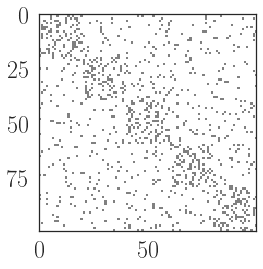

In [6]:
y_out=generate_out_matrix(dim=N, nresponding=n, nclust=5, nnoise=5)

cmap = colors.ListedColormap(["white", "grey"])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots()
ax.imshow(y_out, cmap=cmap, norm=norm)
ax.grid(False) # no gridlines
y = torch.tensor(y_out, device=device).float()
#fig.savefig("graphs/generated_mat_50x50_mod_int.pdf")

In [22]:
G = nx.from_numpy_matrix(y_out)

In [23]:
communities = community.best_partition(G)

In [24]:
community.modularity(communities, G)

0.7999481866156607

* noise 8 modularity = 0.18
* 5 = 0.24
* 3 = 0.46
* 1 = 0.68
* 0 = 0.80

In [25]:
modularity = [0.18, 0.24, 0.46, 0.68, 0.80]

In [7]:
learning_rate = 1e1
epochs = int(2e5)

In [39]:
model = torch.nn.Sequential(
          torch.nn.Linear(N, R),
          torch.nn.Sigmoid(),
          torch.nn.Linear(R,M),
          torch.nn.Sigmoid())
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [40]:
for t in range(epochs):
    # Run the forward pass
    y_pred = model(x)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    loss_series.append(loss.item())
  
    # Zero the gradients before running the backward pass
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights using SGD
    optimizer.step()

In [10]:
per = 0.99
threshold = 0.5
behaviour = 0
behaviours_learnt = []
y_pred_binary = np.abs(np.round(y_pred.data.numpy()+0.5-threshold))
for j in range(len(y)):
    s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
    if s.ratio() > per:
        behaviour += 1
    behaviours_learnt.append(behaviour/N)
behaviour

91

Noise = 0
50% threshold for no noise is 6
75% is 7
95% is 10

Noise = 1
50% is 9
75% 13
95% 18

Noise = 3
50% 14
75% 20
95% 35

Noise = 5
50% 16
75% 21
95% 35

Noise = 8
50% 17
75% 22
95% 35

In [26]:
percent_ninetyfive = [35, 35, 35, 18, 10]
percent_seventyfive = [22, 21, 20, 13, 7]
percent_fifty = [17, 16, 14, 9, 6]

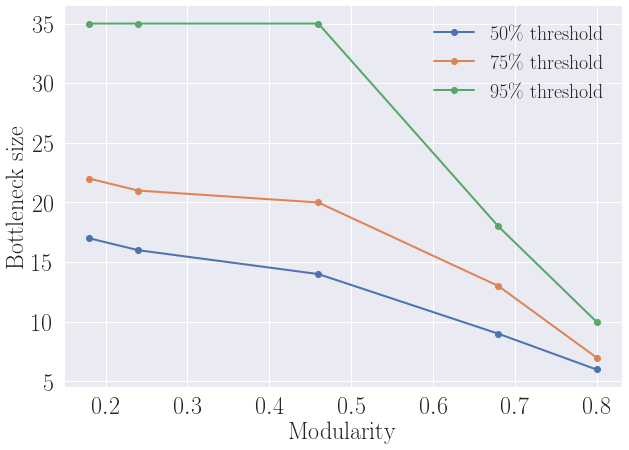

In [37]:
plt.figure(figsize=(10,7))
plt.plot(modularity,percent_fifty,'o-',label = '50\% threshold')
plt.plot(modularity,percent_seventyfive,'o-',label = r'75\% threshold')
plt.plot(modularity,percent_ninetyfive,'o-',label = r'95\% threshold')
plt.ylabel('Bottleneck size')
plt.xlabel('Modularity')
plt.legend()

In [41]:
trained_parameters = []
for param in model.named_parameters():
    trained_parameters.append(param[1].data.numpy())
    
w1 = trained_parameters[0]
b1 = trained_parameters[1]
w2 = trained_parameters[2]
b2 = trained_parameters[3]

## Analyzing weight matrices
### All behviours learnt
* Structure is clearly seen for w2

In [70]:
embedding1 = umap.UMAP().fit_transform(w1)

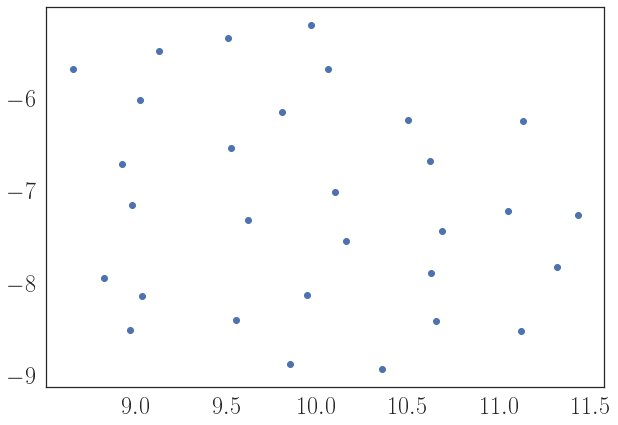

In [78]:
plt.figure(figsize=(10,7))
plt.scatter(embedding1[...,0],embedding1[...,1])

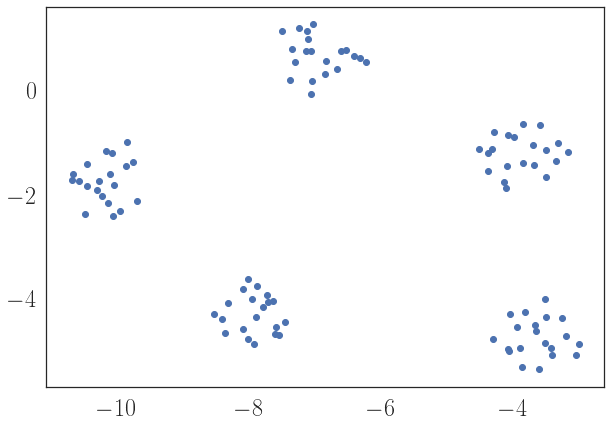

In [79]:
embedding2 = umap.UMAP().fit_transform(w2)
plt.figure(figsize=(10,7))
plt.scatter(embedding2[...,0],embedding2[...,1])

(array([0.0013157 , 0.00977374, 0.0419143 , 0.0873998 , 0.12198381,
        0.12329949, 0.09642171, 0.06164974, 0.01747996, 0.00263139]),
 array([-9.725636 , -7.952176 , -6.1787167, -4.4052567, -2.6317973,
        -0.8583379,  0.9151217,  2.6885812,  4.462041 ,  6.2355003,
         8.00896  ], dtype=float32),
 <a list of 10 Patch objects>)

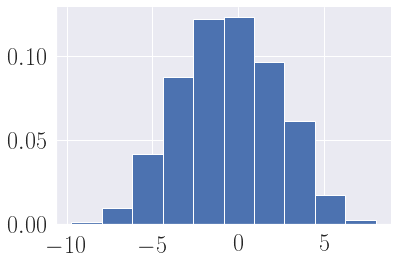

In [73]:
all_weights2 = []
for i in range(len(w2)):
    for j in range(len(w2[0])):
        all_weights2.append(w2[i][j])
plt.hist(all_weights2, density = "True")

(array([0.04576748, 0.15714852, 0.14094762, 0.14054261, 0.13406225,
        0.12555679, 0.11988649, 0.15998365, 0.15674349, 0.03442687]),
 array([-4.0817146 , -3.258714  , -2.4357133 , -1.6127125 , -0.7897118 ,
         0.03328896,  0.8562897 ,  1.6792904 ,  2.5022912 ,  3.3252919 ,
         4.1482925 ], dtype=float32),
 <a list of 10 Patch objects>)

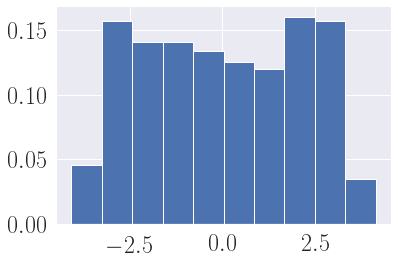

In [74]:
all_weights1 = []
for i in range(len(w1)):
    for j in range(len(w1[0])):
        all_weights1.append(w1[i][j])
plt.hist(all_weights1, density = 'True')

(-10, 10)

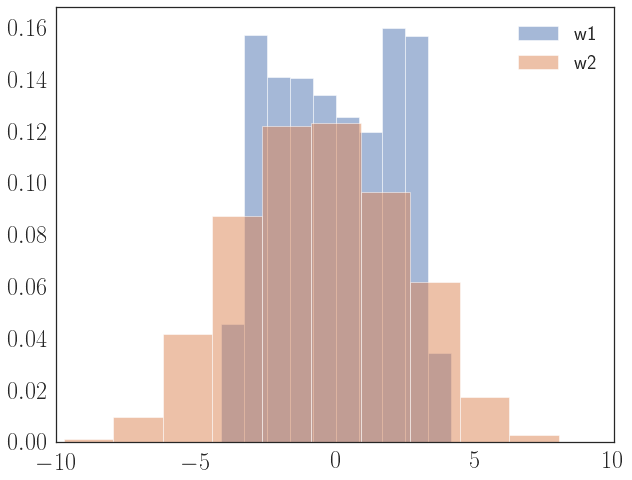

In [81]:
plt.figure(figsize=(10,8))
plt.hist(all_weights1, density = 'True',alpha=0.5, label = 'w1')
plt.hist(all_weights2, density = 'True',alpha=0.5, label = 'w2')
plt.legend()
plt.xlim(-10,10)

* Histogram of entries in the weight matrix w2 are quite gaussian

### Badly trained network

## Context Dependency

In [42]:
# Adding an activated unit
activated_units = 1
x_act = torch.zeros((N,N+activated_units))
for i in range(len(x)):
    x_act[i] = torch.cat((x[i],torch.ones(activated_units,dtype=torch.float32)))

In [43]:
# Activation function
def actfn(x):
    y = x.sigmoid()
    return y

In [44]:
w1 = torch.tensor(np.transpose(w1)).float()
w2 = torch.tensor(np.transpose(w2)).float()
b1 = torch.tensor(b1).float()
b2 = torch.tensor(b2).float()

In [45]:
motor_units = [[] for i in range(len(y_pred_binary))] # Which hidden neurons affect each motor unit
hidden_affected = np.zeros(R) # No. of behaviours affected by each hidden neuron

# What happens when each hidden neuron is forcefully always activated.
for i in range(R):
    activated_hidden = torch.zeros(R)
    activated_hidden[i] = 1000
    
    w_act = torch.zeros((N+activated_units, R))
    for j in range(len(w_act)):
        if j < N:
            w_act[j] = w1[j]
        else:
            w_act[j] = activated_hidden
            
    # Modified predictions of the NN
    y_pred_2 = actfn(actfn(x_act.mm(w_act)+b1).mm(w2)+b2)
    y_pred_2 = y_pred_2.detach().numpy()
    y_pred_2 = np.abs(np.round(y_pred_2))  # Threshold = 0.5
    
    # Explicit comparison of the two outputs
    cmap = colors.ListedColormap(['white','red','yellow','grey'])
    # white: Neuron stays off 
    # red: Neuron is turned off
    # Yellow: Neuron is turned on
    # grey: Neuron stays on
    bounds = [0,0.9,1.9,2.9,3.1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    comparison_array = (y_pred_2)*2 + y_pred_binary
    
    for k in range(len(comparison_array)):
        for indx, comp in enumerate(comparison_array[k]):
            if comp == 1 or comp == 2:
                motor_units[indx].append(i+1)
                
    # Number of behaviours each hidden neuron affects
    for k in range(len(comparison_array)):
        for indx, comp in enumerate(comparison_array[k]):
            if comp == 1 or comp == 2:
                hidden_affected[i] += 1
                break
    
    for units in range(len(motor_units)):
        motor_units[units] = list(set(motor_units[units]))
   
    #fig, ax = plt.subplots(figsize=(6,6))
    #ax.imshow(comparison_array, cmap=cmap, norm=norm)
    #plt.xlabel('Motor units')
    #plt.ylabel('Behaviours')
    #plt.title('Compared output: Hidden neuron {} activated'.format(i+1))   
    #plt.savefig('contextdep1.png')

In [46]:
# Average number of behaviours affected per hidden neuron
avg_affected_behaviours = sum(hidden_affected)/R
avg_affected_behaviours

100.0

Noise = 1
R 2 : 94.5
R 6 : 83.167
R 8 : 76.125
R 10 : 67.4
R 20 : 41.5
R 30 : 16.2
R 40 : 3.475
R 60 : 0.0

Noise = 5
R 2 : 100
R 6 : 86.167
R 8 : 80
R 10 : 71.3
R 20 : 47.65
R 30 : 25.63
R 40 : 16.675
R 60 : 11.2

In [36]:
R_sizes = np.array([2,6,8,10,20,30,40,60])

(-1, 105)

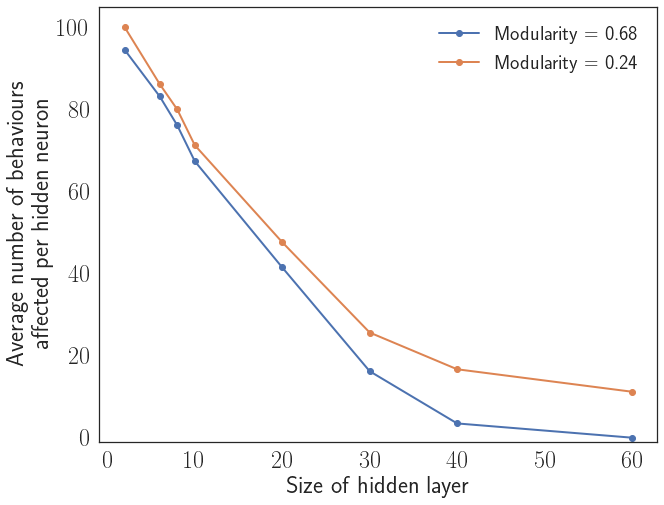

In [53]:
values1 = np.array([94.5, 83.167, 76.125, 67.4, 41.5, 16.2, 3.475, 0.0])
values5 = np.array([100, 86.167, 80, 71.3, 47.65, 25.63, 16.675, 11.2])
plt.figure(figsize=(10,8))
plt.plot(R_sizes, values1, 'o-', label = 'Modularity = 0.68')
plt.plot(R_sizes, values5, 'o-', label = 'Modularity = 0.24')
plt.xlabel('Size of hidden layer')
plt.ylabel('Average number of behaviours \n affected per hidden neuron')
plt.legend()
plt.ylim(-1,105)